In [69]:
import numpy as np
from utils import *

from skimage.color import rgb2gray
from PIL import Image
from scipy.signal import convolve2d
from scipy.ndimage import rank_filter
from scipy.stats import norm
from skimage import transform
import matplotlib
from matplotlib import pyplot as plt
import cv2
import math
import random
import pickle

SEED = 17
random.seed(SEED)
np.random.seed(SEED)

1. [5 points] Load both images, convert to double and to grayscale.

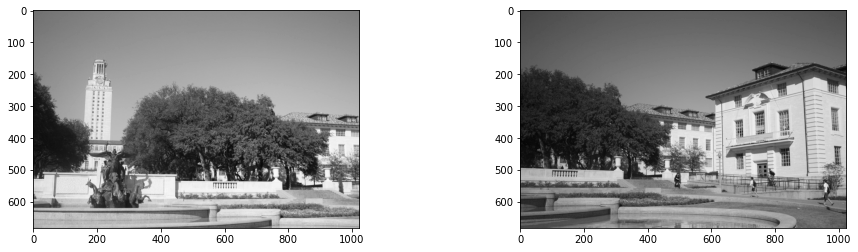

In [70]:
def loadGrayscaleImage(path):
    img = np.asarray(Image.open(path), dtype=np.float64)
    img_gray = rgb2gray(img)
    return img_gray

left = loadGrayscaleImage('./data/uttower_left.JPG')
left *= (255.0 / np.max(left))
right = loadGrayscaleImage('./data/uttower_right.JPG')
right *= (255.0 / np.max(right))

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[1].imshow(right, cmap='gray')

2. [5 points] Detect feature points in both images. You can use harris.m for Harris corner detection.

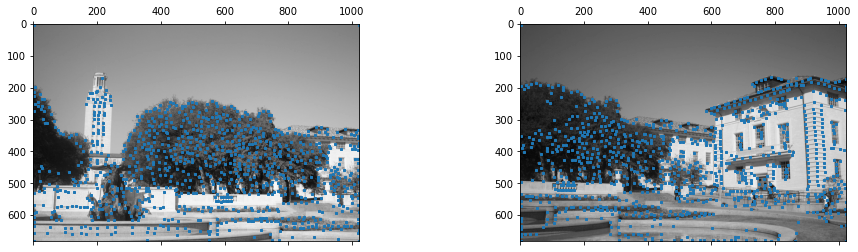

In [71]:
sigma = 3.2
thres = 400
r = 3

left_corners, left_r, left_c = harris(left, sigma, thresh=thres, radius=r)
right_corners, right_r, right_c = harris(right, sigma, thresh=thres, radius=r)

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[0].spy(left_corners, markersize=2)
ax[1].imshow(right, cmap='gray')
ax[1].spy(right_corners, markersize=2)

3. [10 points] Extract local neighborhoods around every keypoint in both images, and form descriptors simply by "flattening" the pixel values in each neighborhood to one-dimensional vectors. Experiment with different neighborhood sizes to see which one works the best.

In [72]:
r_circ = 4
left_circles = np.vstack([
    left_c,
    left_r,
    r_circ * np.ones(left_r.shape[0])
]).T
right_circles = np.vstack([
    right_c,
    right_r,
    r_circ * np.ones(right_r.shape[0])
]).T

left_sift = find_sift(left, left_circles)
right_sift = find_sift(right, right_circles)
left_sift.shape

(926, 128)

In [73]:
l_descriptor_coord = left_circles[:,:2]
r_descriptor_coord = right_circles[:, :2]

4. [10 points] Compute distances between every descriptor in one image and every descriptor in the other image. You can use dist2.m for fast computation of Euclidean distance. Alternatively, experiment with computing normalized correlation, or Euclidean distance after normalizing all descriptors to have zero mean and unit standard deviation. Optionally, feel free to experiment with SIFT descriptors. Here is some find_sift.m for computing SIFT descriptors of circular regions.

In [74]:
distance = dist2(left_sift, right_sift)
distance.shape

(960, 926)

5. [10 points] Select putative matches based on the matrix of pairwise descriptor distances obtained above. You can select all pairs whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances.

In [75]:
def margsort(m):
    idx_arr = np.argsort(m.ravel())
    idx_pairs = np.dstack(np.unravel_index(idx_arr, m.shape))
    return np.squeeze(idx_pairs, 0)

descriptor_pairs = margsort(distance)
descriptor_pairs[:, [0, 1]] = descriptor_pairs[:, [1, 0]]
descriptor_pairs.shape

(888960, 2)

In [76]:
n = 400
img1coord = np.zeros((n, 2))
img2coord = np.zeros((n, 2))
for i, (idx1, idx2) in enumerate(descriptor_pairs[:n]):
    img1coord[i] = l_descriptor_coord[idx1]
    img2coord[i] = r_descriptor_coord[idx2]
    # print(distance[idx2, idx1])

here is what top $n$ nearest pair looks like in actual image.

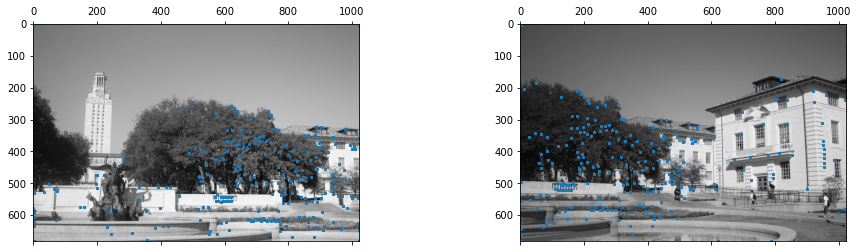

In [77]:
l_top_keypoints = np.zeros_like(left, dtype=np.bool_)
r_top_keypoints = np.zeros_like(right, dtype=np.bool_)
for i in range(img1coord.shape[0]):
    left_y, left_x = img1coord[i]
    right_y, right_x = img2coord[i]
    l_top_keypoints[int(left_x), int(left_y)] = True
    r_top_keypoints[int(right_x), int(right_y)] = True

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[0].spy(l_top_keypoints, markersize=2)
ax[1].imshow(right, cmap='gray')
ax[1].spy(r_top_keypoints, markersize=2)

6. [40 points] Run RANSAC to estimate a homography mapping one image onto the other. You need to write the code for RANSAC by yourself. Report the number of inliers and the average residual for the inliers (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.

In [78]:
def computeHomography(img1_coord, img2_coord):
    '''Direct Linear Transforms'''
    n = img1_coord.shape[0]
    A = np.zeros((n * 2, 9))
    for i in range(n):
        x, y = img1_coord[i]
        xp, yp = img2_coord[i]
        A[i*2] = np.array([x, y, 1, 0, 0, 0, -xp * x, -xp * y, -xp])
        A[i*2+1] = np.array([0, 0, 0, x, y, 1, -yp * x, -yp * y, -yp])
    
    [U, S, Vt] = np.linalg.svd(A.T @ A)
    h_hat = Vt[-1]
    # print(A @ h_hat)
    return np.reshape(h_hat, (3, 3))


def predictCoord(H, coord_in):
    homo_coord = np.append(coord_in, 1)
    proj = H @ homo_coord.T
    proj = proj / proj[-1]
    return proj[:2]

def predictCoords(H, coords_in):
    pred_all = np.zeros_like(coord_in)
    for i in range(coord_in.shape[0]):
        pred_all[i] = predictCoord(H, coords_in[i])
    
    return pred_all

def getInliers(H, pairs, coord1, coord2, thres=10):
    left_inliers = []
    right_inliers = []
    for idx1, idx2 in pairs:
        proj = predictCoord(H, coord1[idx1])
        distance = np.linalg.norm(proj - coord2[idx2])
        if distance < thres:
            left_inliers.append(coord1[idx1])
            right_inliers.append(coord2[idx2])
            
    return (np.asarray(left_inliers), np.asarray(right_inliers))

def RANSAC(pairs, lcoord, rcoord, N=10, thres=10):
    max_inliers_count = 0
    best_H = np.zeros((3, 3))
    inliers = None
    
    for i in range(N):
        # get a sample of 4 pair of descriptors
        sample_indices = np.random.randint(0, pairs.shape[0], size=4)
        coord_img1 = np.zeros((4, 2))
        coord_img2 = np.zeros((4, 2))
        for i, idx in enumerate(sample_indices):
            # print(pairs[idx])
            idx1, idx2 = pairs[idx]
            coord_img1[i] = lcoord[idx1]
            coord_img2[i] = rcoord[idx2]
        
        H = computeHomography(coord_img1, coord_img2)
        curr_inliers = getInliers(H, pairs, lcoord, rcoord, thres)
        n_inliers = curr_inliers[0].shape[0]
        if n_inliers > max_inliers_count:
            max_inliers_count = n_inliers
            best_H = H
            inliers = curr_inliers
        
    # Find all inlier matches using the highest scoring homography to calculate new refined homography

    # Re-compute least-squares H estimate
    # using all of the inliers
    return computeHomography(inliers[0], inliers[1]), inliers

In [79]:
H, inliers = RANSAC(descriptor_pairs[:n], l_descriptor_coord, r_descriptor_coord, N=10000, thres=3)
H

array([[-2.16950393e-03,  1.21885669e-04,  9.59543805e-01],
       [-2.80801382e-04, -2.04577270e-03,  2.81538444e-01],
       [-4.60059941e-07, -4.30388293e-08, -1.67488895e-03]])

The total number of inliers is:

In [80]:
inliers[0].shape[0]

173

And here are the locations of inliers in two images

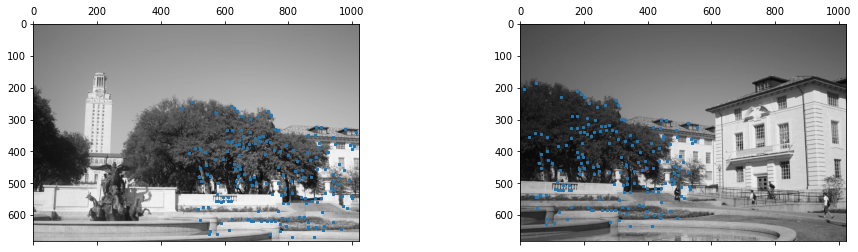

In [81]:
left_inliers = np.zeros_like(left, dtype=np.bool_)
right_inliers = np.zeros_like(right, dtype=np.bool_)
for i in range(inliers[0].shape[0]):
    left_y, left_x = inliers[0][i]
    right_y, right_x = inliers[1][i]
    left_inliers[int(left_x), int(left_y)] = True
    right_inliers[int(right_x), int(right_y)] = True

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[0].spy(left_inliers, markersize=2)
ax[1].imshow(right, cmap='gray')
ax[1].spy(right_inliers, markersize=2)

7. [10 points] Warp one image onto the other using the estimated transformation. To do this, you will need to learn about `maketform` and `imtransform` functions in MATLAB or similar functions in Python. You can use off-the-shelf code for this transformation (warping).

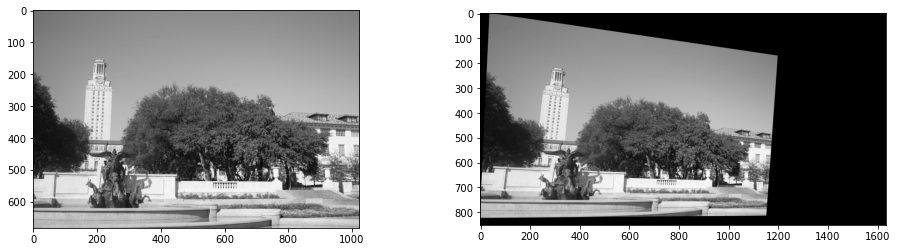

In [82]:
warp = warp_image(left, H)
fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[1].imshow(warp, cmap='gray')

8. [10 points] Create a new image big enough to hold the panorama and composite the two images into it. You can composite by simply averaging the pixel values where the two images overlap. Your result should look something like this (but hopefully with a more precise alignment):

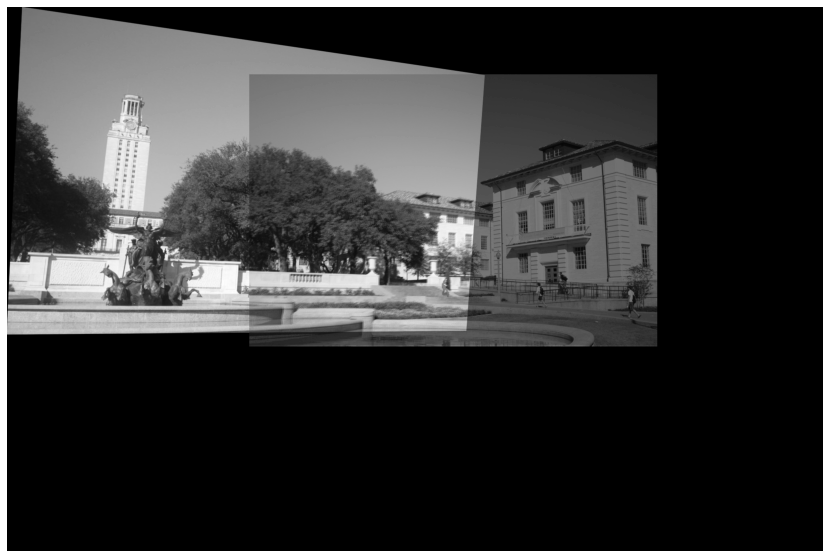

In [83]:
h = left.shape[0] + right.shape[0]
w = left.shape[1] + right.shape[1]
result = np.zeros((h, w))

h_offset = 169
w_offset = 608

result[:warp.shape[0], :warp.shape[1]] = warp
result[h_offset:right.shape[0]+h_offset, w_offset:right.shape[1]+w_offset] = right

# average the overlapping part of two images
for i in range(h_offset, warp.shape[0]):
    for j in range(w_offset, warp.shape[1]):
        result[i, j] = (warp[i, j] + result[i, j]) / 2

plt.figure(figsize=(20,10))
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()